# Imports

In [84]:
# basics 
from watermark import watermark
import pandas  as pd
pd.options.display.float_format = '{:,.2f}'.format
import joblib
import numpy  as np
import optuna

# plot
import matplotlib.pyplot as plt
import plotly.express    as px
import seaborn           as sns

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# encoders
from category_encoders       import OneHotEncoder,TargetEncoder,BinaryEncoder


# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold


In [85]:
print( watermark( packages = 'pandas,seaborn,joblib,numpy,optuna,matplotlib,sklearn,category_encoders,xgboost,lightgbm' ) )

pandas           : 2.1.4
seaborn          : 0.13.2
joblib           : 1.4.2
numpy            : 1.26.4
optuna           : 4.2.1
matplotlib       : 3.10.0
sklearn          : 1.5.2
category_encoders: 2.6.3
xgboost          : 1.7.6
lightgbm         : 4.6.0



## 1 - Load Data

In [86]:
df = pd.read_csv( r'data/fraudTrain.csv' )
df_test = pd.read_csv(r'data/fraudTest.csv')
df.head().to_csv('sample.data.csv') 

In [88]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [89]:
# fraud transactions
df_fraud = df.loc[ df['is_fraud'] == 1, :].sort_values( by = ['cc_num','trans_date_trans_time'], ascending= True ) 


# no fraud transactions
df_no_fraud = df.loc[df['is_fraud'] == 0, :].sort_values( by = ['cc_num','trans_date_trans_time'], ascending= True ) 

In [90]:
# tempo medio transações fraudadas
df_fraud['previous_transaction'] = df_fraud['trans_date_trans_time'].shift()
df_fraud['lag_transacoes'] = df_fraud['trans_date_trans_time'] - df_fraud['previous_transaction']
df_fraud['previous_transaction'] = df_fraud['previous_transaction'].fillna(0)
df_fraud['lag_transacoes'] = df_fraud['lag_transacoes'].dt.total_seconds()

print(f'Median time fraud transaction is {df_fraud['lag_transacoes'].median():,.2f}')
print(f'Avg time fraud transaction is {df_fraud['lag_transacoes'].mean():,.2f}')

Median time fraud transaction is 3,894.00
Avg time fraud transaction is 2,830.52


In [91]:
# tempo medio transações fraudadas
df_no_fraud['previous_transaction'] = df_no_fraud['trans_date_trans_time'].shift()
df_no_fraud['lag_transacoes'] = df_no_fraud['trans_date_trans_time'] - df_no_fraud['previous_transaction']
df_no_fraud['previous_transaction'] = df_no_fraud['previous_transaction'].fillna(0)
df_no_fraud['lag_transacoes'] = df_no_fraud['lag_transacoes'].dt.total_seconds()

print(f'Median time no fraud transaction is {df_no_fraud['lag_transacoes'].median():,.2f}')
print(f'Avg time no fraud transaction is {df_no_fraud['lag_transacoes'].mean():,.2f}')

Median time no fraud transaction is 16,611.00
Avg time no fraud transaction is 35.98


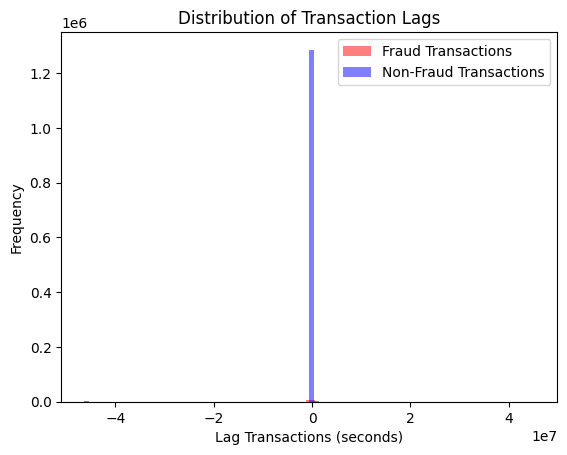

In [92]:
plt.hist(df_fraud['lag_transacoes'], bins=50, alpha=0.5, label='Fraud Transactions', color='red')
plt.hist(df_no_fraud['lag_transacoes'], bins=50, alpha=0.5, label='Non-Fraud Transactions', color='blue')
plt.legend()
plt.xlabel('Lag Transactions (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Lags')
plt.show()


In [93]:
# valor medio transações fraud
print(f'Avg amt fraud transaction {df_fraud['amt'].mean():,.2f}')
print(f'Median amt fraud transaction {df_fraud['amt'].median():,.2f}')

Avg amt fraud transaction 531.32
Median amt fraud transaction 396.50


In [94]:
# valor medio transações no fraud
print(f'Avg amt no fraud transaction {df_no_fraud['amt'].mean():,.2f}')
print(f'Median amt no fraud transaction {df_no_fraud['amt'].median():,.2f}')

Avg amt no fraud transaction 67.67
Median amt no fraud transaction 47.28


In [95]:
df_fraud['amt_to_avg'] = df_fraud['amt'] / df_fraud.groupby('cc_num')['amt'].transform('mean')
df_fraud['amt_to_avg']

102490   0.06
102556   0.06
104145   0.09
106627   3.93
106628   1.24
         ... 
713362   1.19
713531   0.38
714377   1.35
715082   1.30
715096   1.20
Name: amt_to_avg, Length: 7506, dtype: float64

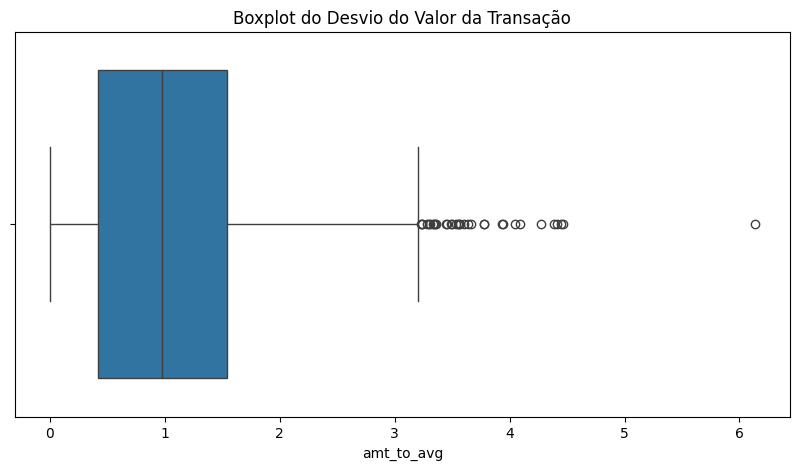

In [96]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_fraud['amt_to_avg'])
plt.title('Boxplot do Desvio do Valor da Transação')
plt.show()


In [97]:
df_no_fraud['amt_to_avg'] = df_no_fraud['amt'] / df_no_fraud.groupby('cc_num')['amt'].transform('mean')
df_no_fraud['amt_to_avg']

1017      0.13
2724      0.96
2726      1.49
2882      0.63
2907      0.49
          ... 
1294934   0.93
1295369   1.14
1295587   3.80
1296206   0.04
1296427   0.60
Name: amt_to_avg, Length: 1289169, dtype: float64

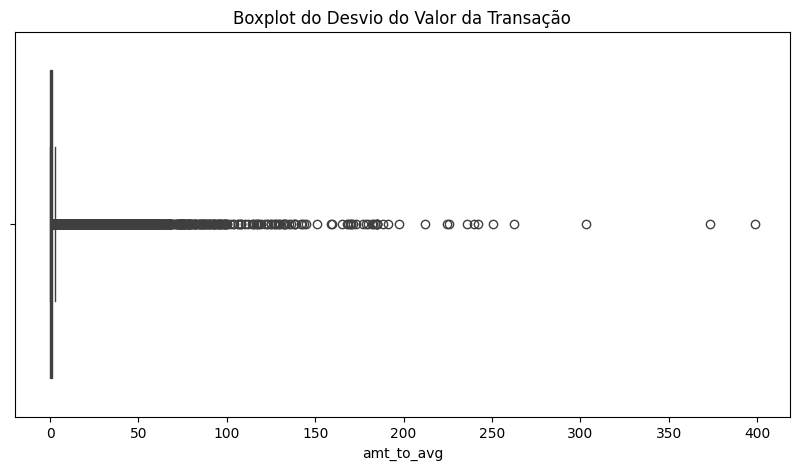

In [98]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_no_fraud['amt_to_avg'])
plt.title('Boxplot do Desvio do Valor da Transação')
plt.show()


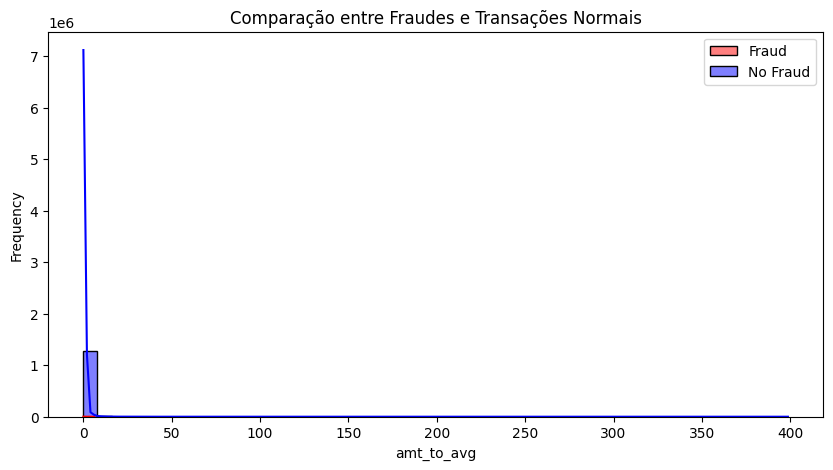

In [99]:
plt.figure(figsize=(10,5))
sns.histplot(df_fraud['amt_to_avg'], bins=50, kde=True, color='red', label='Fraud')
sns.histplot(df_no_fraud['amt_to_avg'], bins=50, kde=True, color='blue', label='No Fraud', alpha=0.5)
plt.xlabel('amt_to_avg')
plt.ylabel('Frequency')
plt.title('Comparação entre Fraudes e Transações Normais')
plt.legend()
plt.show()



In [115]:
df_fraud['transactions_per_day'] = df_fraud.groupby(df_fraud['trans_date_trans_time'].dt.date)['trans_num'].transform('count')
print(f'Avg transaction per day fraud {df_fraud['transactions_per_day'].mean():,.2f}')

Avg transaction per day fraud 20.65


In [116]:
df_no_fraud['transactions_per_day'] = df_no_fraud.groupby(df_no_fraud['trans_date_trans_time'].dt.date)['trans_num'].transform('count')
print(f'Avg transaction per day no fraud {df_no_fraud['transactions_per_day'].mean():,.2f}')

Avg transaction per day no fraud 2,804.30


In [110]:
df_fraud['transactions_per_month'] = df.groupby(df['trans_date_trans_time'].dt.to_period('M'))['trans_num'].transform('count')
print(f'Avg monthly transactions number {df_fraud['transactions_per_month'].mean():,.2f}')

Avg monthly transactions number 73,494.45


In [111]:
df_no_fraud['transactions_per_month'] = df_no_fraud.groupby(df['trans_date_trans_time'].dt.to_period('M'))['trans_num'].transform('count')
print(f'Avg monthly transactions number {df_no_fraud['transactions_per_month'].mean():,.2f}')

Avg monthly transactions number 77,444.82
